# Counterfactual Baseline: If No Competitor Events

Train a simple baseline model on pre-closure data and project expected sales after the closure date.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [2]:
# Load data
df = pd.read_csv('cleaned_sales_report_2024-2025.csv')
df['date'] = pd.to_datetime(df['date'])


In [3]:
# Aggregate to daily revenue
df_daily = df.groupby('date')['total_amt'].sum().reset_index()
df_daily['day_index'] = (df_daily['date'] - df_daily['date'].min()).dt.days
df_daily['is_weekend'] = df_daily['date'].dt.dayofweek.isin([5, 6]).astype(int)


In [4]:
# Event dates
closure_start_date = pd.to_datetime('2025-04-01')
new_open_date = pd.to_datetime('2025-08-01')


In [5]:
# Train baseline model on pre-closure period only
train_daily = df_daily[df_daily['date'] < closure_start_date].copy()
X_train = train_daily[['day_index', 'is_weekend']]
y_train = train_daily['total_amt']
model = LinearRegression()
model.fit(X_train, y_train)


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [6]:
# Predict counterfactual baseline for all dates after closure
impact_period = df_daily[df_daily['date'] >= closure_start_date].copy()
X_impact = impact_period[['day_index', 'is_weekend']]
impact_period['predicted_baseline'] = model.predict(X_impact)
impact_period['daily_uplift'] = impact_period['total_amt'] - impact_period['predicted_baseline']
total_uplift = impact_period['daily_uplift'].sum()
print(f"Total revenue above baseline (post-closure onward): ₹{total_uplift:,.2f}")


Total revenue above baseline (post-closure onward): ₹943,023.61


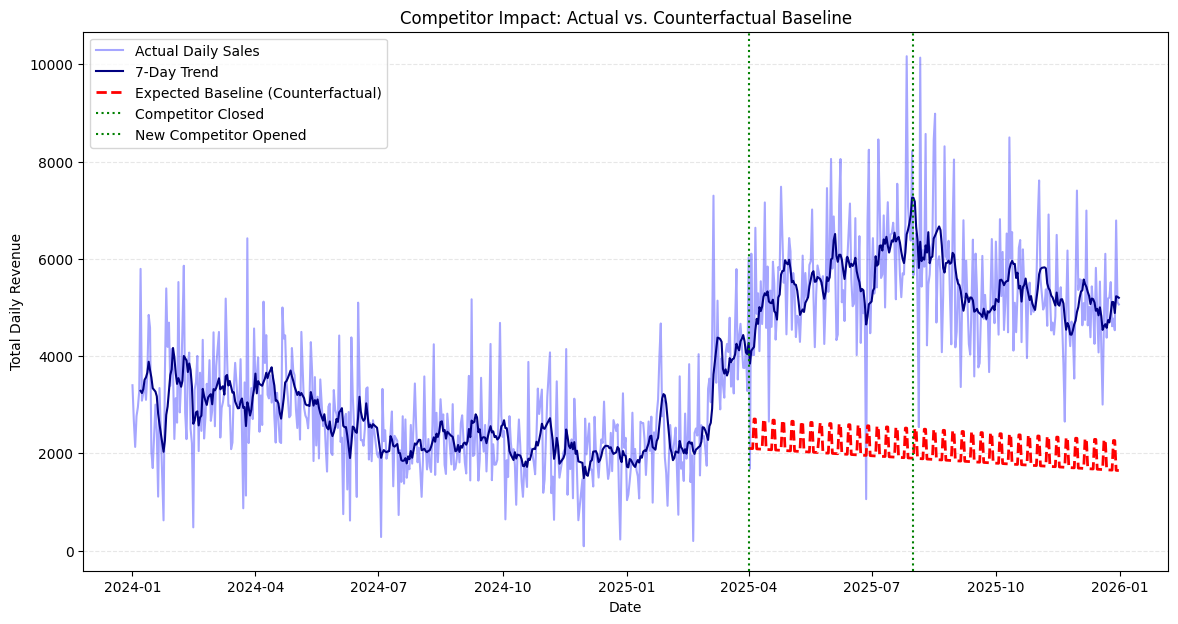

In [7]:
# Plot actual vs counterfactual baseline
plt.figure(figsize=(14, 7))
plt.plot(df_daily['date'], df_daily['total_amt'], color='blue', alpha=0.35, label='Actual Daily Sales')
plt.plot(df_daily['date'], df_daily['total_amt'].rolling(7).mean(), color='navy', label='7-Day Trend')
plt.plot(impact_period['date'], impact_period['predicted_baseline'], color='red', linestyle='--', linewidth=2, label='Expected Baseline (Counterfactual)')
plt.axvline(closure_start_date, color='green', linestyle=':', label='Competitor Closed')
plt.axvline(new_open_date, color='green', linestyle=':', label='New Competitor Opened')
plt.title('Competitor Impact: Actual vs. Counterfactual Baseline')
plt.xlabel('Date')
plt.ylabel('Total Daily Revenue')
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()
